<a href="https://colab.research.google.com/github/Emmnmm/sta365hw7/blob/main/07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Q1

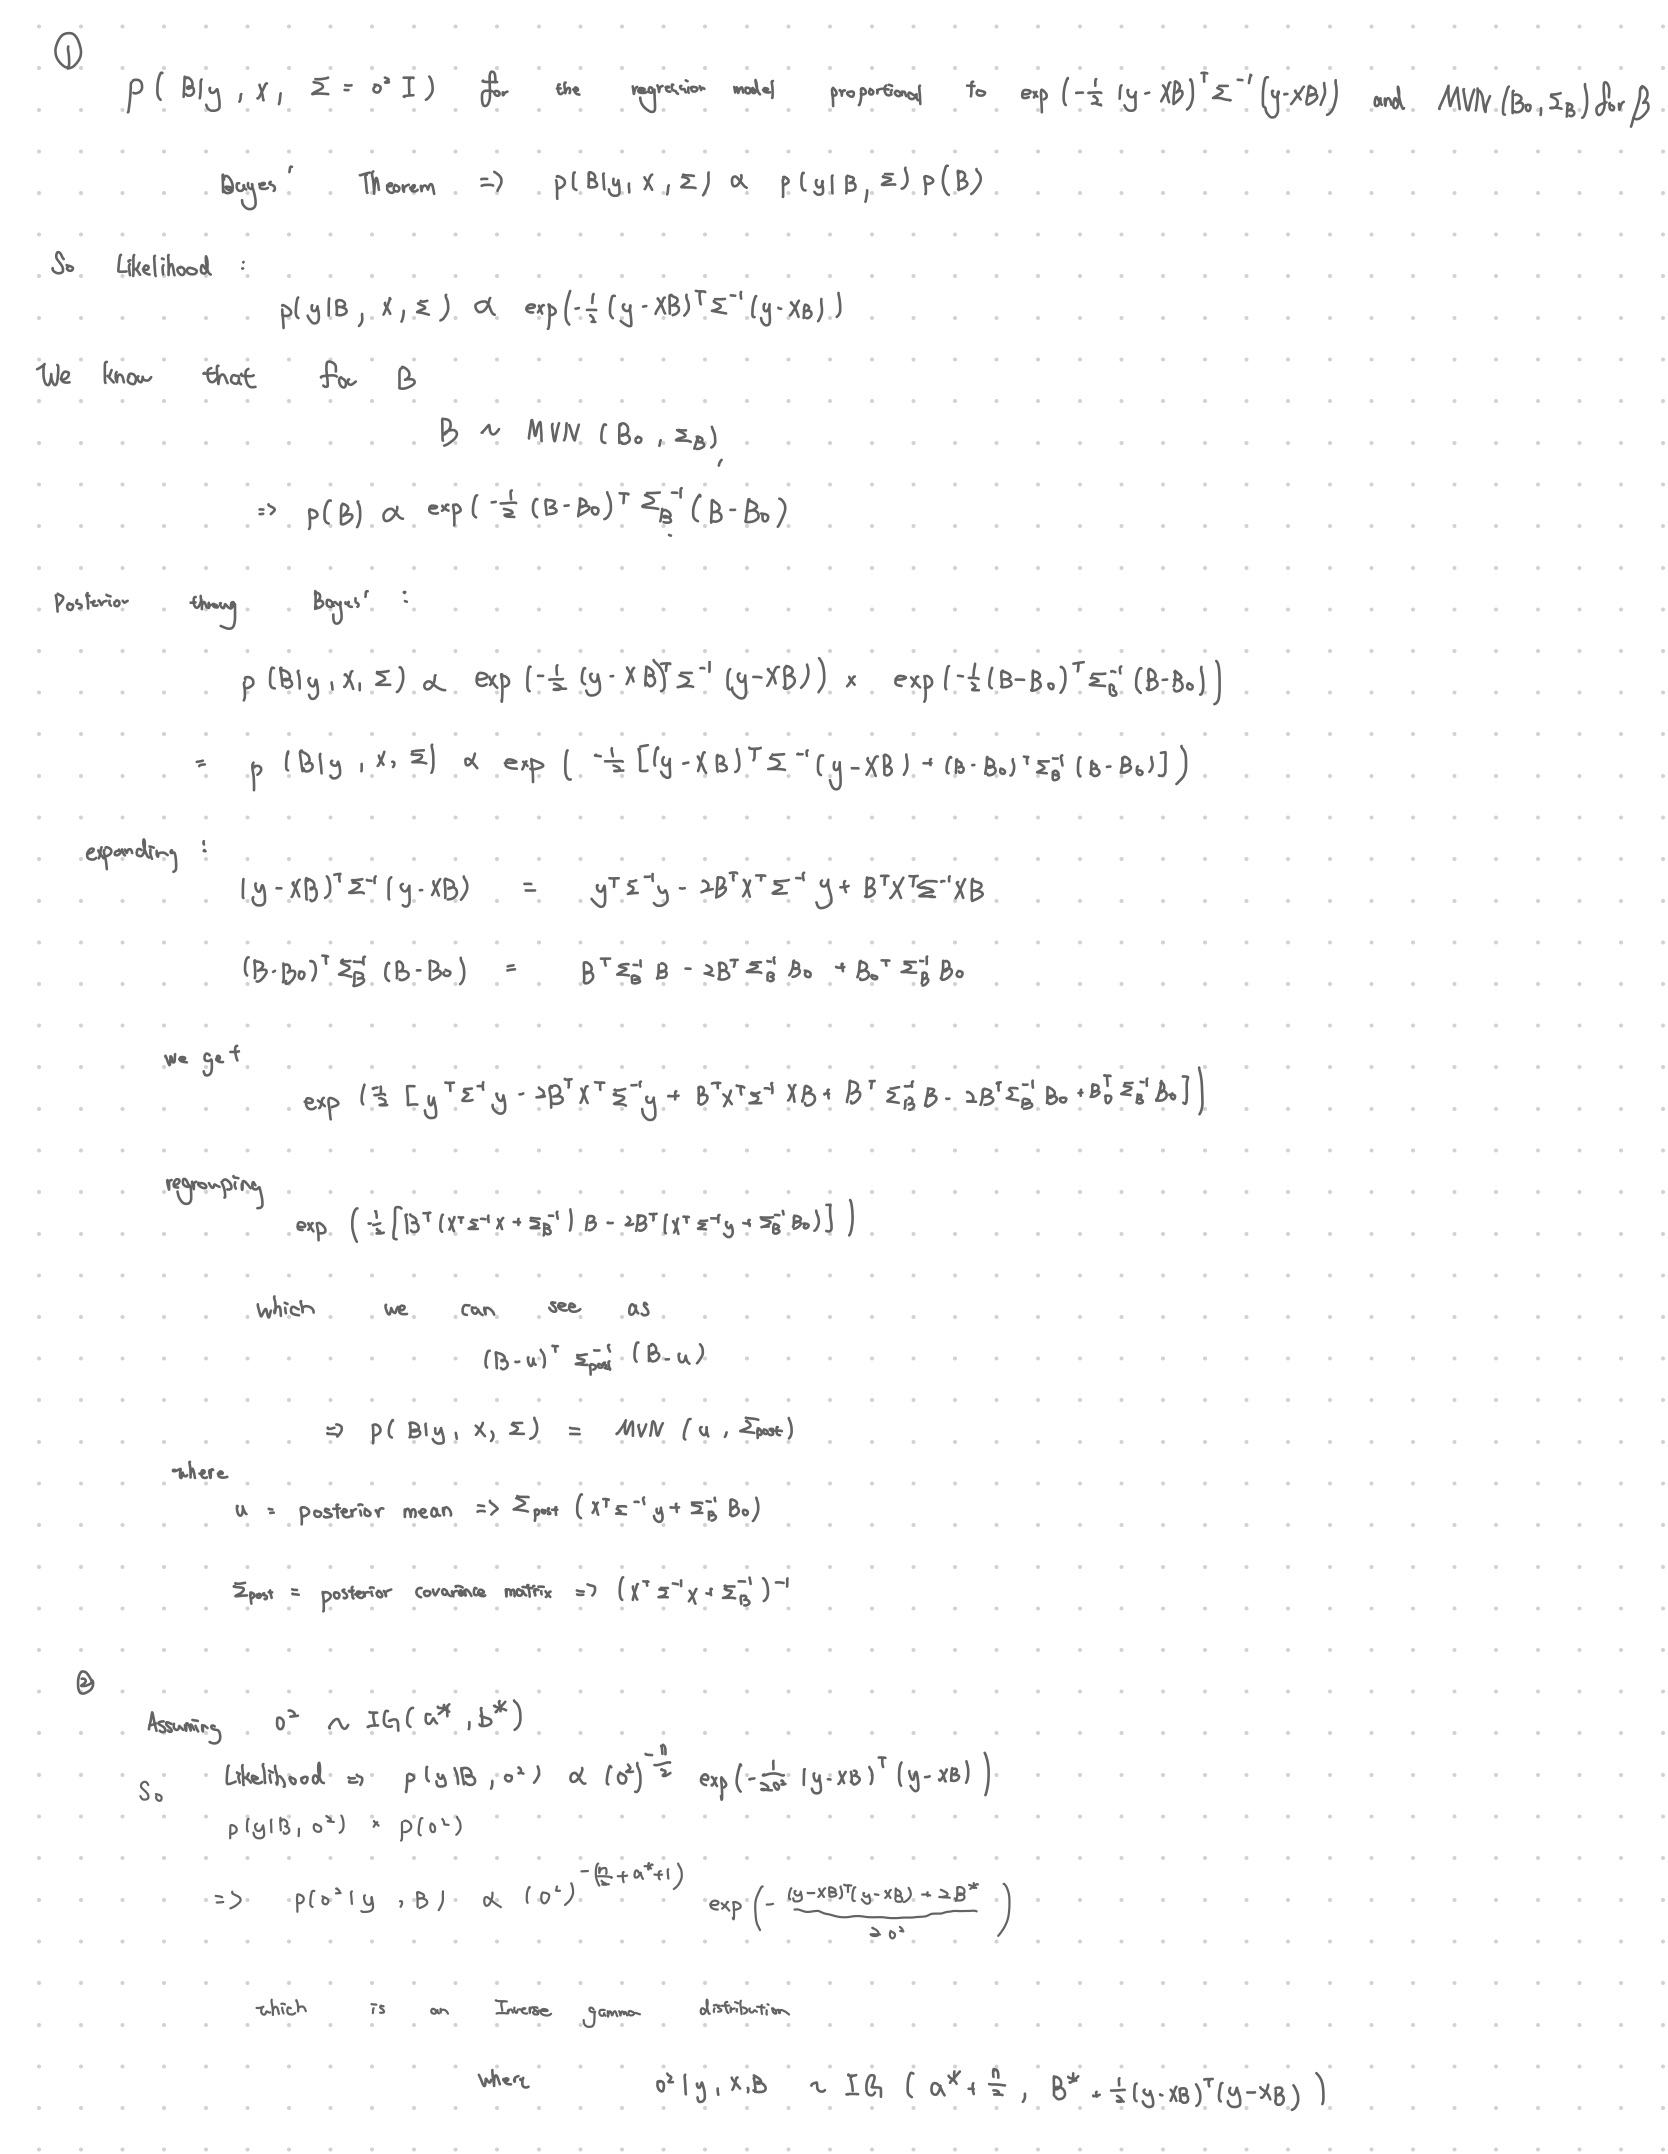

# Q2



In [78]:
# Dataset from Kaggle
# Link: https://www.kaggle.com/datasets/amulyas/penguin-size-dataset/data
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
from sklearn.preprocessing import StandardScaler



# Loading
df = pd.read_csv("penguins_size.csv")


# Check for missing values in the dataset
df.isnull().sum()

# Drop rows with missing values
df = df.dropna()




In [79]:
# Features
features = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm']

# Set target
y = df['body_mass_g']

# Set up X using the selected features
X = df[features]

# Print shapes
print("X shape:", X.shape)
print("y shape:", y.shape)

# Fit and transform the data to standardize it
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Standardize the explanatory variables (features)

with pm.Model() as model:
    # Priors
    betas = pm.Normal('betas', mu=0, sigma=0.5, shape=X_scaled.shape[1])  # prior for betas
    sigma = pm.HalfNormal('sigma', sigma=5)

    # Likelihood
    mu = pm.math.dot(X_scaled, betas)
    y_obs = pm.Normal('y', mu=mu, sigma=sigma, observed=y)  # Use standardized y if applicable

    # Sampling
    trace = pm.sample(1000, return_inferencedata=True, target_accept=0.95)




X shape: (334, 3)
y shape: (334,)


Output()

array([[<Axes: title={'center': 'betas'}>,
        <Axes: title={'center': 'betas'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

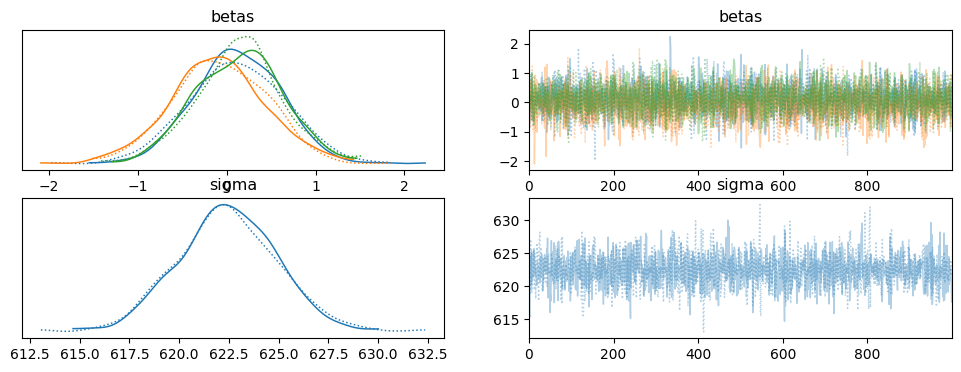

In [80]:
# Plot trace for model convergence
az.plot_trace(trace)


In [74]:
# Check summary statistics
az.summary(trace, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[0],0.092,0.501,-0.906,1.085,0.011,0.012,2245.0,1206.0,1.0
betas[1],-0.080,0.510,-1.135,0.865,0.010,0.013,2421.0,1374.0,1.0
betas[2],0.158,0.498,-0.820,1.082,0.010,0.012,2487.0,1300.0,1.0
sigma,625.551,2.455,620.918,630.575,0.046,0.033,2798.0,1432.0,1.0


array([<Axes: title={'center': 'betas\n0'}>,
       <Axes: title={'center': 'betas\n1'}>,
       <Axes: title={'center': 'betas\n2'}>,
       <Axes: title={'center': 'sigma'}>], dtype=object)

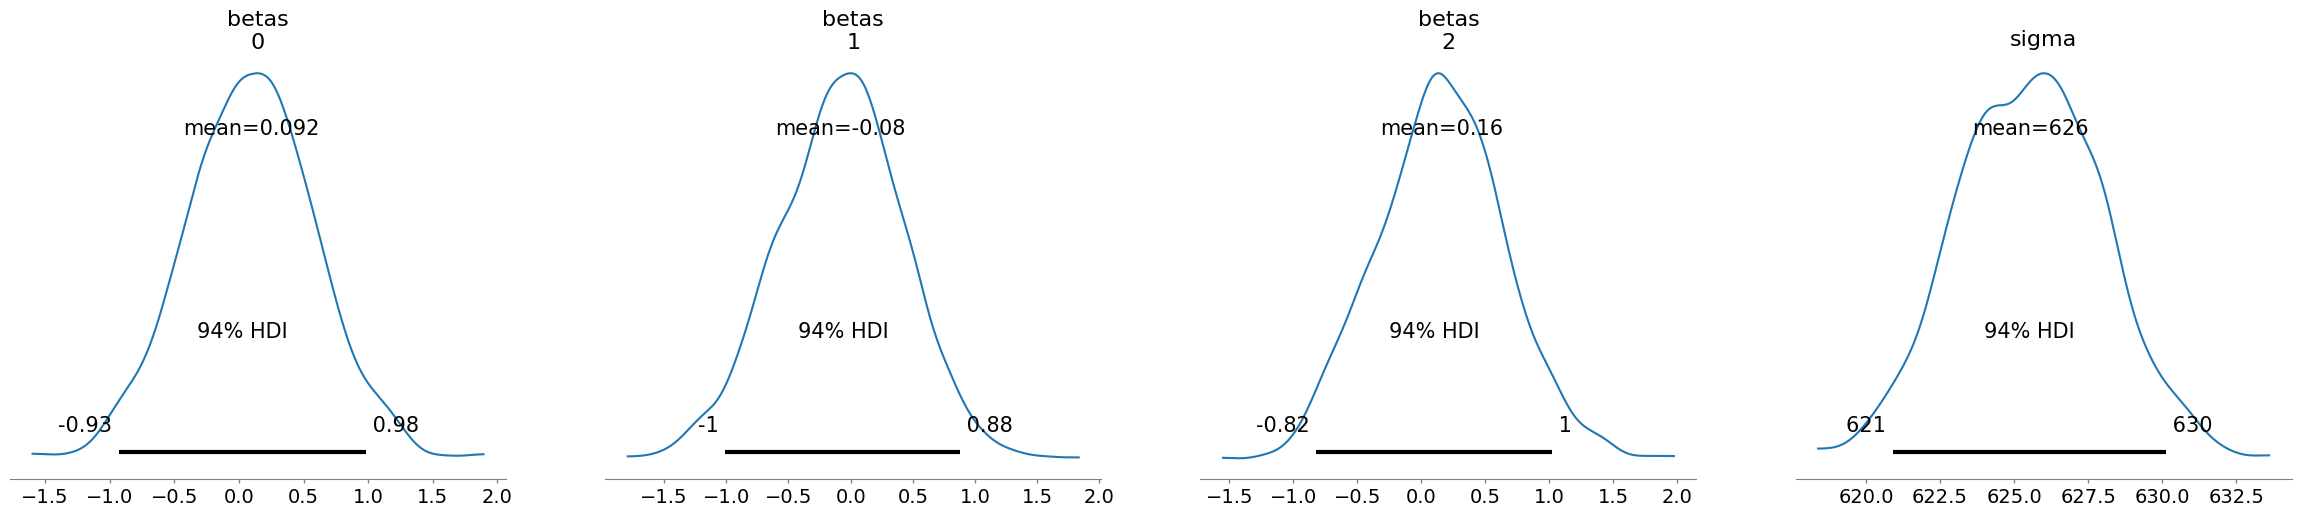

In [75]:
# Plot the posterior distributions for all parameters
az.plot_posterior(trace)

# Q3

In [121]:
# Load your data (after introducing outliers as before)
df = pd.read_csv("penguins_size.csv")
df = df.dropna()  # Drop NaN rows

# Define your features and target
features = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm']
X = df[features]
y = df['body_mass_g']

# Introduce outliers
np.random.seed(222)
outlier_indices = np.random.choice(X.index, size=6, replace=False)

# Modify culmen_length_mm to introduce outliers (e.g., adding 50 mm to certain rows)
X.loc[outlier_indices, 'culmen_length_mm'] += 50  # Adding 50mm to the 'culmen_length_mm'

# Modify the target variable (body_mass_g) to introduce outliers
y.loc[outlier_indices] += np.random.uniform(500, 1500, size=6)  # Adding 500-1500g to the 'body_mass_g' value

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Bayesian Linear Regression with robust priors
with pm.Model() as model:
    # Hyperpriors for the precision (tau)
    nu = pm.Gamma('nu', alpha=2, beta=1)  # Hyperprior for the degrees of freedom of the Student's t-distribution

    # Priors for betas
    betas = pm.Normal('betas', mu=0, sigma=0.5, shape=X_scaled.shape[1])

    # Common precision (tau)
    tau = pm.HalfNormal('tau', sigma=5)

    # Individual precision for each data point
    tau_i = pm.Gamma('tau_i', alpha=nu/2, beta=nu/2, shape=len(y))  # Gamma prior for each data point precision

    # Likelihood with Student's t-distribution for robustness
    mu = pm.math.dot(X_scaled, betas)
    y_obs = pm.Normal('y', mu=mu, sigma=1/(tau * tau_i), observed=y)  # Normal likelihood with robust variance

    # Sampling
    trace = pm.sample(1000, return_inferencedata=True, target_accept=0.95)

# Check posterior distributions
az.summary(trace, hdi_prob=0.95)


<ipython-input-121-e742142375ed>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[outlier_indices, 'culmen_length_mm'] += 50  # Adding 50mm to the 'culmen_length_mm'


Output()

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[0],-0.004,0.468,-0.956,0.937,0.007,0.013,4846.0,1350.0,1.00
betas[1],0.007,0.499,-0.930,0.968,0.008,0.013,4128.0,1112.0,1.00
betas[2],0.004,0.512,-1.035,1.031,0.007,0.014,5642.0,1409.0,1.00
nu,23.886,3.589,17.312,30.872,0.187,0.132,366.0,857.0,1.00
tau,0.000,0.000,0.000,0.000,0.000,0.000,3771.0,1825.0,1.00
...,...,...,...,...,...,...,...,...,...
tau_i[329],0.971,0.259,0.457,1.455,0.004,0.003,3705.0,1238.0,1.00
tau_i[330],0.984,0.258,0.502,1.493,0.004,0.003,3821.0,957.0,1.00
tau_i[331],0.941,0.251,0.471,1.421,0.004,0.003,3616.0,1299.0,1.00
tau_i[332],0.969,0.262,0.447,1.465,0.004,0.003,4460.0,1384.0,1.00


In [122]:
# Extract tau_i posterior samples
tau_i_posterior_samples = trace.posterior['tau_i'].values  # Shape: (chains, draws, tau_i_dim_0)

# Check the shape of the posterior samples for tau_i
print(tau_i_posterior_samples.shape)
# Compute the 95th percentile of tau_i across chains and draws
tau_i_95th_percentile = np.percentile(tau_i_posterior_samples, 95, axis=(0, 1))

# Identify data points where tau_i is above the 95th percentile (outliers)
outliers = np.where(tau_i_95th_percentile > np.percentile(tau_i_95th_percentile, 95))[0]
print("Outlier indices based on tau_i:", outliers)
# Print the outlier data points (based on indices)
outlier_data = df.iloc[outliers]
print(outlier_data)


(2, 1000, 334)
Outlier indices based on tau_i: [ 16  37  48  54  58  60  66  74  92  96 102 110 136 148 167 168 196]
       species     island  culmen_length_mm  culmen_depth_mm  \
21      Adelie     Biscoe              37.7             18.7   
42      Adelie      Dream              36.0             18.5   
54      Adelie     Biscoe              34.5             18.1   
60      Adelie     Biscoe              35.7             16.9   
64      Adelie     Biscoe              36.4             17.1   
66      Adelie     Biscoe              35.5             16.2   
72      Adelie  Torgersen              39.6             17.2   
80      Adelie  Torgersen              34.6             17.2   
98      Adelie      Dream              33.1             16.1   
102     Adelie     Biscoe              37.7             16.0   
108     Adelie     Biscoe              38.1             17.0   
116     Adelie  Torgersen              38.6             17.0   
142     Adelie      Dream              32.1        

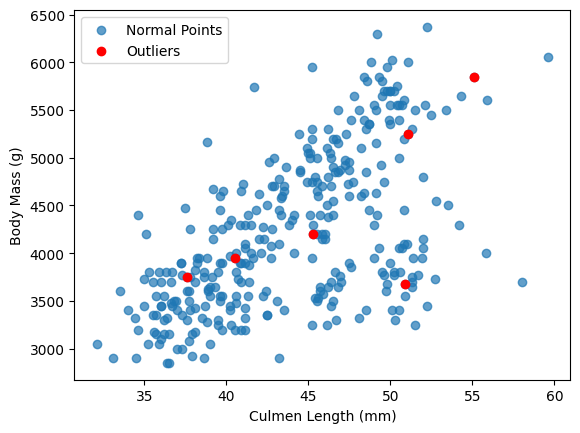

In [124]:
# plottt


# Get the outlier data
outliers = df.iloc[outlier_indices]

# Plotting the normal points and outliers
plt.scatter(df['culmen_length_mm'], df['body_mass_g'], label='Normal Points', alpha=0.7)
plt.scatter(outliers['culmen_length_mm'], outliers['body_mass_g'], color='red', label='Outliers', alpha=1)

plt.xlabel('Culmen Length (mm)')
plt.ylabel('Body Mass (g)')
plt.legend()
plt.show()

Leverage for outliers: [0.01759868 0.00983602 0.01378169 0.00607692 0.01283634 0.00782   ]
Leverage for non-outliers: [0.00912335 0.0075793  0.0041795  0.00889418 0.01321452 0.01024678
 0.00931885 0.01016035 0.01812626 0.02577701 0.00802262 0.00708491
 0.01578253 0.0090588  0.02034806 0.01548564 0.00985465 0.00849082
 0.00727372 0.14054309 0.00824983 0.00797527 0.00618348 0.01695302
 0.01768343 0.0121229  0.00590417 0.00757682 0.00610211 0.01995473
 0.01013331 0.01044519 0.00963326 0.00780426 0.00946486 0.00461468
 0.00760678 0.00870096 0.01007583 0.00585374 0.00869937 0.00652231
 0.01680988 0.00700409 0.00625168 0.00714384 0.1142357  0.00807741
 0.00504278 0.00741509 0.00546682 0.01480785 0.01048881 0.0182147
 0.00960103 0.00445493 0.0102718  0.00428603 0.00834182 0.00651484
 0.00860319 0.00835855 0.00982897 0.00526124 0.00421211 0.00563871
 0.00700783 0.00443431 0.0061468  0.00888206 0.01224773 0.00619773
 0.0082689  0.00339887 0.00734638 0.01051939 0.00566956 0.01194519
 0.00931792 

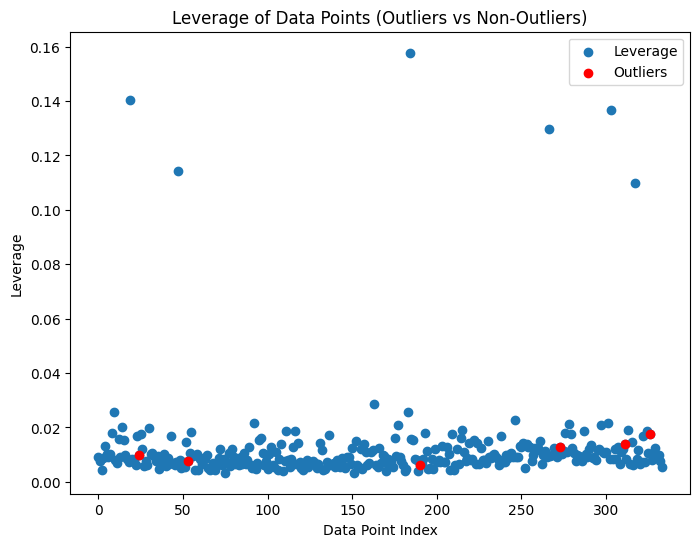

In [125]:
import numpy as np
import matplotlib.pyplot as plt

# Extract the posterior for betas (regression coefficients)
betas_posterior = trace.posterior['betas'].values  # Shape: (chains, draws, betas_dim_0)

# Extract the posterior for tau_i (individual precision for each data point)
tau_i_posterior = trace.posterior['tau_i'].values  # Shape: (chains, draws, tau_i_dim_0)

# Calculate the posterior mean for betas and tau_i
beta_mean = betas_posterior.mean(axis=(0, 1))  # Mean across chains and draws
tau_i_mean = tau_i_posterior.mean(axis=(0, 1))  # Mean across chains and draws

# Standardize the features (X_scaled is already standardized)
X_scaled_with_intercept = np.c_[np.ones(X_scaled.shape[0]), X_scaled]  # Add intercept term

# Compute the Hat matrix using the posterior mean of betas
XTX_inv = np.linalg.inv(X_scaled_with_intercept.T @ X_scaled_with_intercept)  # (X^T X)^-1
hat_matrix = X_scaled_with_intercept @ XTX_inv @ X_scaled_with_intercept.T  # Calculate H

# Leverage values (diagonal of the Hat matrix)
leverage = np.diag(hat_matrix)

# Compare outliers vs non-outliers based on leverage
outliers_leverage = leverage[outlier_indices]
non_outliers_leverage = leverage[~np.isin(np.arange(len(leverage)), outlier_indices)]

# Compare leverage values
print("Leverage for outliers:", outliers_leverage)
print("Leverage for non-outliers:", non_outliers_leverage)

# Visualize leverage values for all data points
plt.figure(figsize=(8, 6))
plt.scatter(np.arange(len(leverage)), leverage, label="Leverage")
plt.scatter(outlier_indices, outliers_leverage, color='red', label="Outliers", zorder=5)
plt.xlabel("Data Point Index")
plt.ylabel("Leverage")
plt.title("Leverage of Data Points (Outliers vs Non-Outliers)")
plt.legend()
plt.show()


In [128]:
az.summary(trace, hdi_prob=0.95)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[0],-0.004,0.468,-0.956,0.937,0.007,0.013,4846.0,1350.0,1.00
betas[1],0.007,0.499,-0.930,0.968,0.008,0.013,4128.0,1112.0,1.00
betas[2],0.004,0.512,-1.035,1.031,0.007,0.014,5642.0,1409.0,1.00
nu,23.886,3.589,17.312,30.872,0.187,0.132,366.0,857.0,1.00
tau,0.000,0.000,0.000,0.000,0.000,0.000,3771.0,1825.0,1.00
...,...,...,...,...,...,...,...,...,...
tau_i[329],0.971,0.259,0.457,1.455,0.004,0.003,3705.0,1238.0,1.00
tau_i[330],0.984,0.258,0.502,1.493,0.004,0.003,3821.0,957.0,1.00
tau_i[331],0.941,0.251,0.471,1.421,0.004,0.003,3616.0,1299.0,1.00
tau_i[332],0.969,0.262,0.447,1.465,0.004,0.003,4460.0,1384.0,1.00


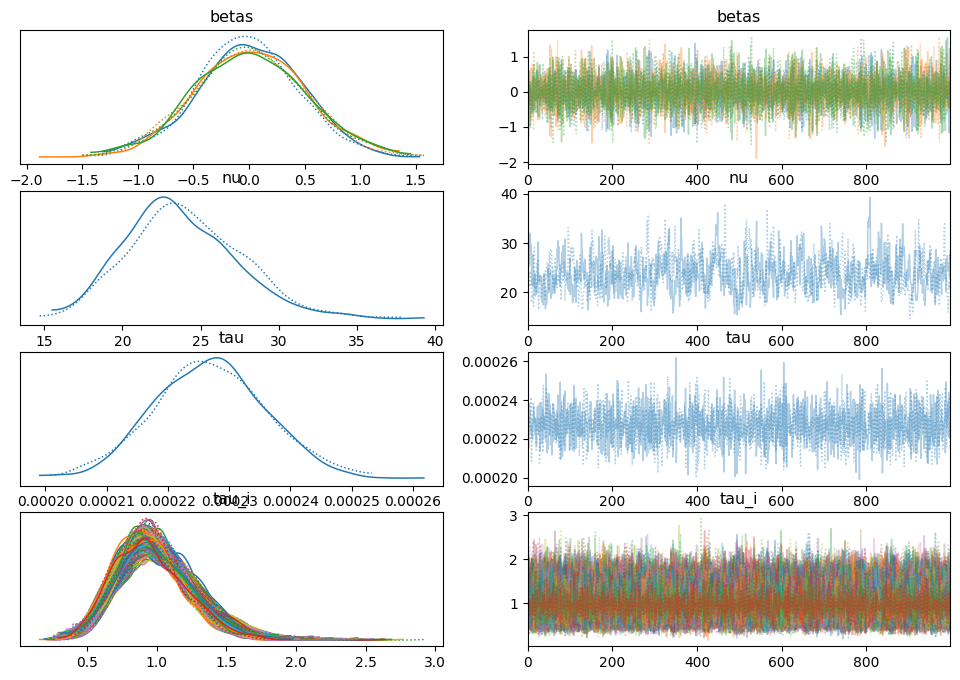

/usr/local/lib/python3.11/dist-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (334) in plot_posterior, generating only 40 plots
  warnings.warn(


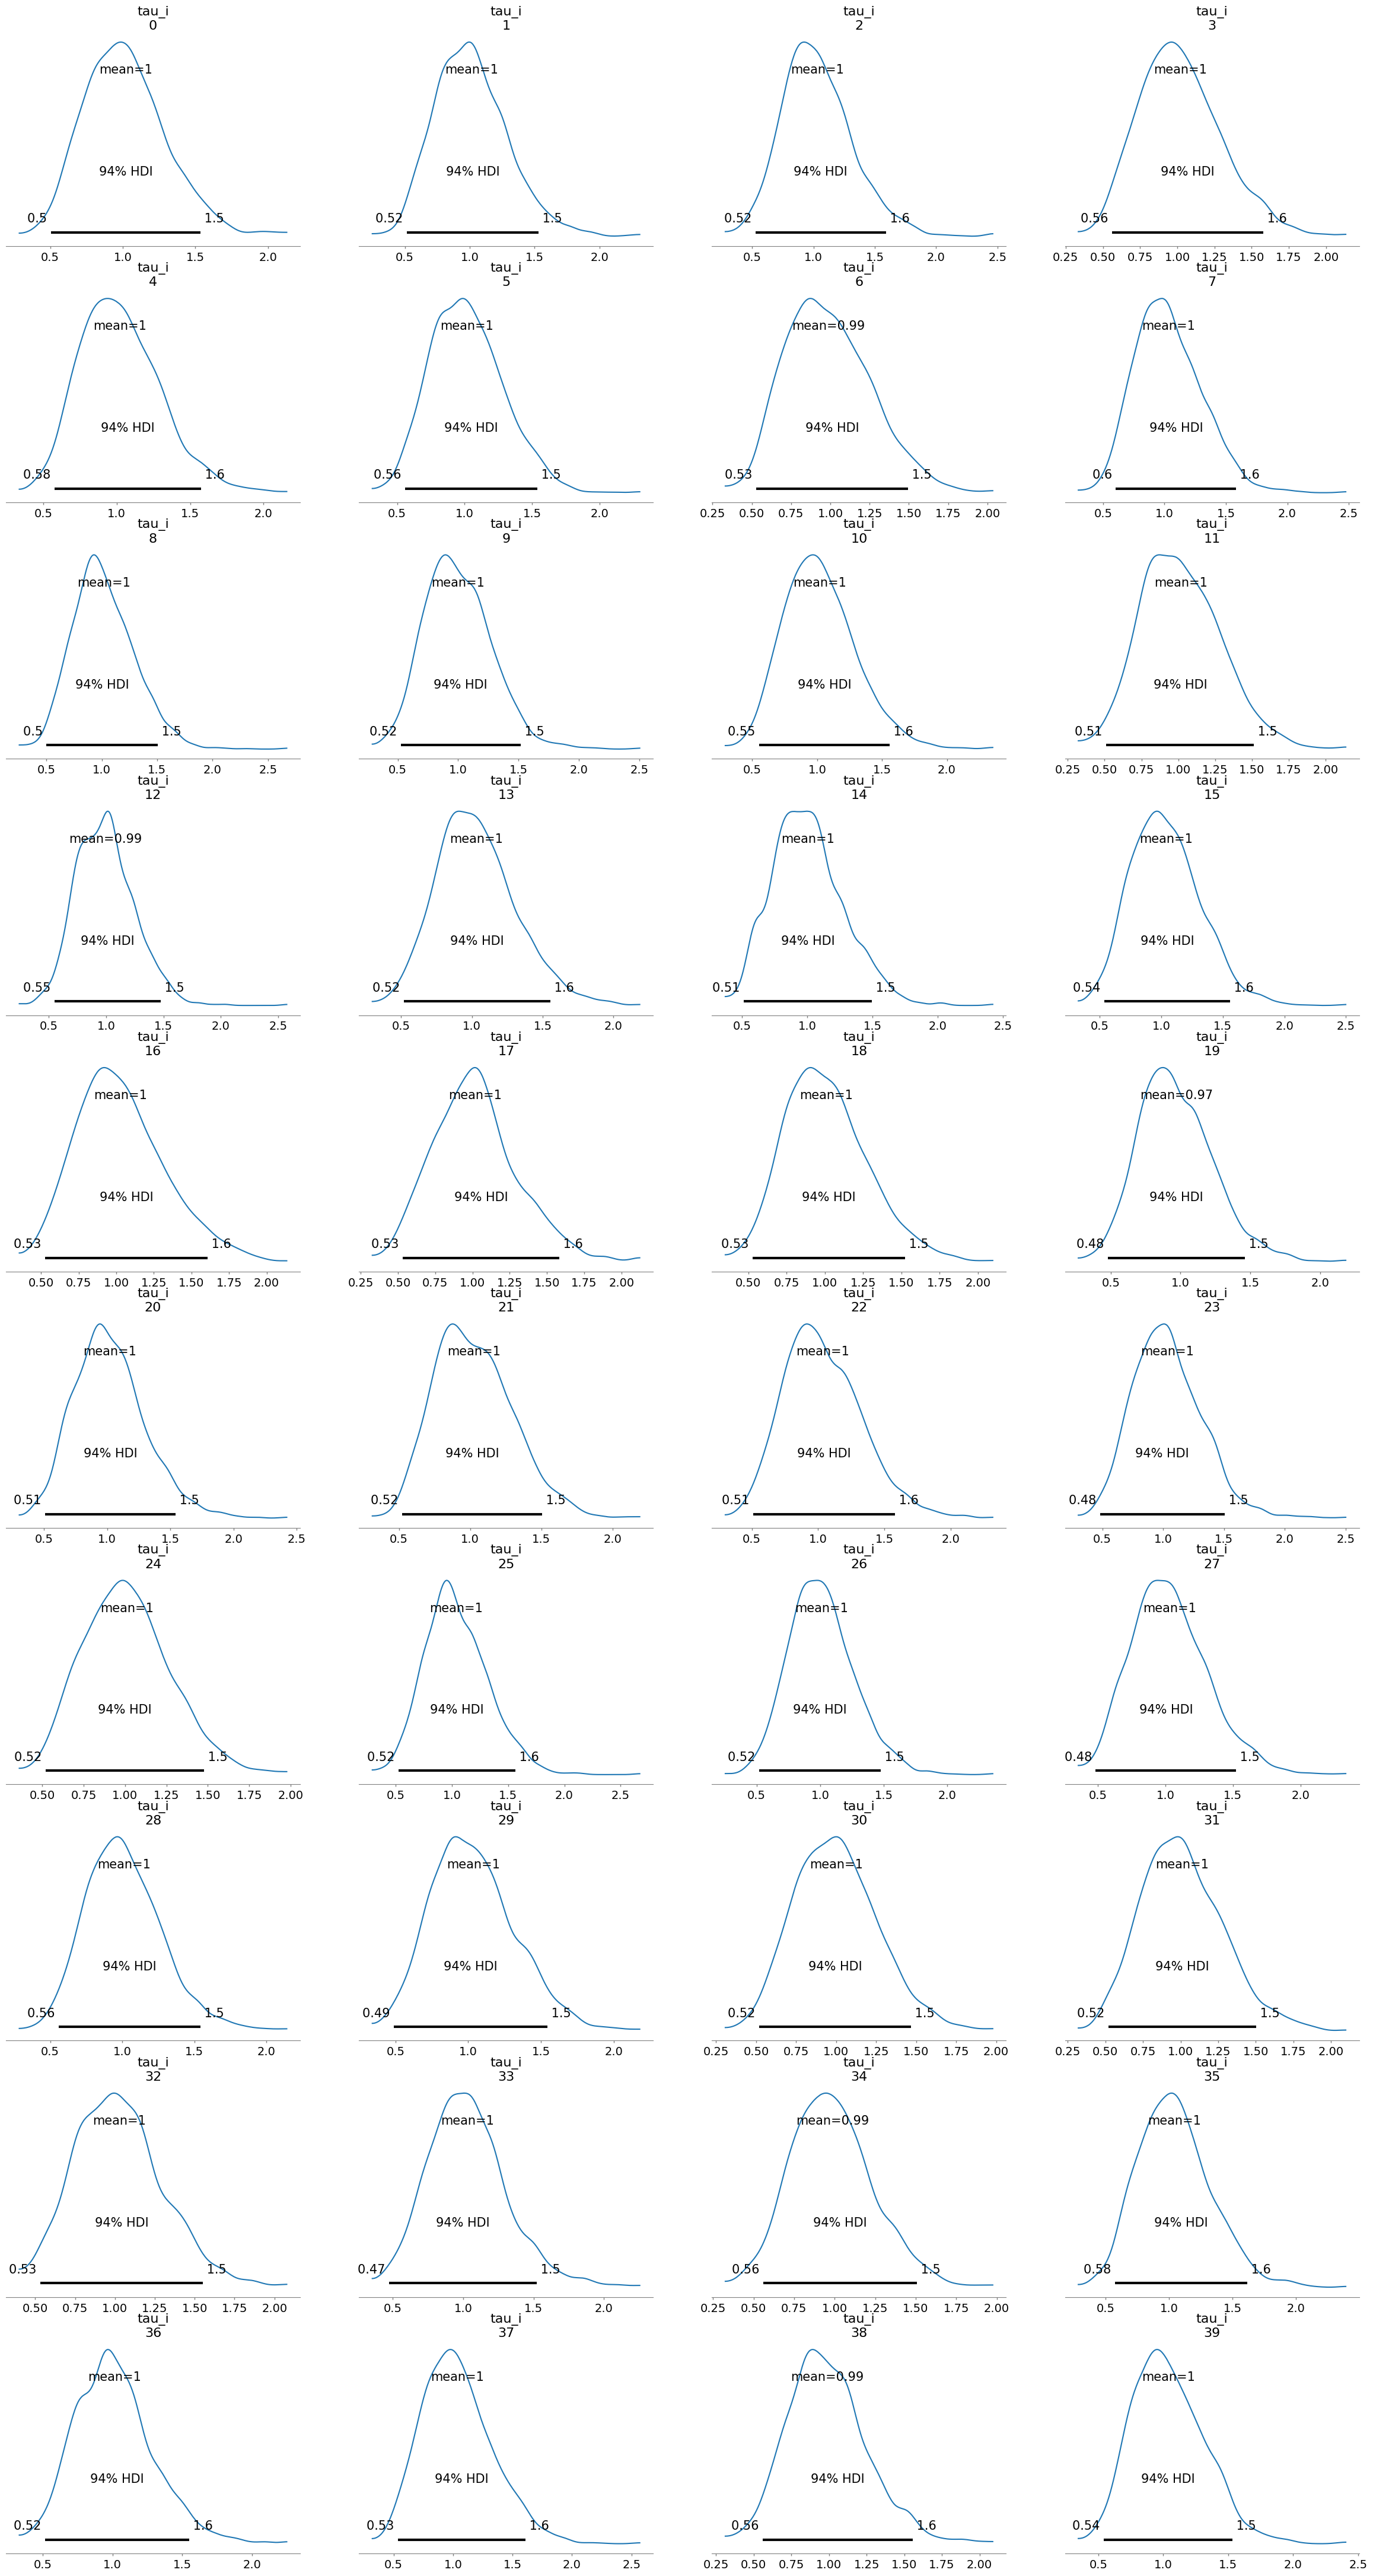

In [129]:
az.plot_trace(trace)
plt.show()
az.plot_posterior(trace, var_names=["tau_i"])
plt.show()